In [1]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import gc
gc.collect()

51

In [4]:
data_path = '../data/' # Where your customer and performance data located
output_path = 'TO BE FILLED IN' # Where do you want to output the final dataset
filename = 'TO BE FILLED IN' # What do you want to name the output dataset 

In [5]:
Client = pd.read_excel('../data/Client_info_20191118.xlsx',sheet_name='Sheet1')

## Data Loading & Preprocessing

### 1. Customer Dataset

In [6]:
Customer_old = pd.read_csv(data_path + 'Customer_Data_Request_20191121.csv')
Customer = pd.read_csv(data_path + 'Customer_Data_Request_20191217.csv')

In [7]:
# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)
# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])

In [8]:
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date
0,100001115,1000,02/24/2014,6880.0,230.0,58229,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,Employed,NaN
1,100001120,1000,02/24/2014,6520.0,362.0,109245,Repeat Buyer,94 Brentwood Ln,NaN,Valley Stream,NY,11581,Employed,NaN
2,100001141,1000,02/25/2014,10290.0,337.0,127226,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,Employed,NaN
3,100001158,1000,02/24/2014,5190.0,419.0,49375,Repeat Buyer,1036 Braddish Ave,NaN,Baltimore,MD,21216,Employed,NaN
4,100001169,1000,02/24/2014,7500.0,448.0,69460,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,Employed,NaN


In [9]:
# Check Missing Values
Customer.isnull().sum(axis=0)

Unique_Customer_ID              0
Unique_Company_ID               0
Enrollment_Date                 0
Assigned_Spending_Limit         0
Customer_Tenure               110
Customer_Salary             67538
Prior_Customer_Flag             0
Street1                        71
Street2                    483722
City                           68
State                           1
Zip                             6
Status                        308
Term_Date                  491485
dtype: int64

In [8]:
# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.'
# Assigned_Spending_Limit has 0
# Customer_Tenure has NaN
Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
                    (~Customer['Customer_Salary'].isin([0, '.'])) & 
                    (Customer['Customer_Salary'].notnull())&
                    (Customer['Customer_Tenure'].notnull())]



In [9]:
 # Formating conversion
Customer['Customer_Salary'] = Customer['Customer_Salary'].astype(float)
Customer['Enrollment_Date'] = pd.to_datetime(Customer['Enrollment_Date'].astype(str), format='%m/%d/%Y')

In [12]:
Customer.dtypes

Unique_Customer_ID                  int64
Unique_Company_ID                   int64
Enrollment_Date            datetime64[ns]
Assigned_Spending_Limit           float64
Customer_Tenure                   float64
Customer_Salary                   float64
Prior_Customer_Flag                object
Street1                            object
Street2                            object
City                               object
State                              object
Zip                                object
Status                             object
Term_Date                          object
dtype: object

### 2. Performance Dataset

In [10]:
Perf = pd.read_csv(data_path + 'Performance_Data_Request_20191204.csv')
Perf_11 = pd.read_csv(data_path + 'Performance_Data_Request_20191217.csv')

In [11]:
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns = {' Unique_Order_ID':'Unique_Order_ID','Order_date':'Order_Date'},inplace = True)
Perf.rename(columns = {'items_ordered':'Items_Ordered','EMPSTATUS':'Customer_Status'},inplace = True)
Perf = Perf.append(Perf_11, ignore_index=True)

In [12]:
# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format = '%Y%m')
Perf = Perf.sort_values(['Unique_Order_ID','Year_and_Month'],ascending = [False,True])

# Create new column - YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

# Assign Payment Order as a new column
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Treat 151+ ad CO as BAD
Perf['Bad']=0
Perf.loc[Perf['Default_Status'].isin(['151+','Chargeoff']),'Bad']=1
# Create a flag Ever_Bad to distinguish first time bad and non-first time bad 
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os Loss, using Losses for C/O orders and Current_Balance for 151+ orders
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status']=='Chargeoff','2os_loss'] = Perf.loc[Perf['Default_Status']=='Chargeoff','Losses']
Perf.loc[Perf['Default_Status']=='151+','2os_loss'] = Perf.loc[Perf['Default_Status']=='151+','Current_Balance']


# Perf['Enrollment_Date'] = pd.to_datetime(Perf['Enrollment_Date'].astype(str), format = '%m/%d/%Y')

In [13]:
# Some cleaning here
Perf.loc[Perf['Order_Amount']=='.','Order_Amount']=np.nan
Perf['Order_Amount'] = Perf['Order_Amount'].astype(float)

Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount']!=0)]

In [14]:
Perf = Perf.merge(Customer, how='left',on='Unique_Customer_ID')

In [18]:
df_17 = Perf[Perf['Year']>=2017]

In [19]:
fed = df_17[df_17['Unique_Company_ID']==2049]

In [20]:
fed_bad = fed[(fed['Bad']==1) & (fed['Ever_Bad']<=1)]
fed_good = fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)

In [22]:
fed_bad.groupby('Year_and_Month').agg({'Order_Amount':"mean",'Assigned_Spending_Limit':'mean','Unique_Order_ID':'count'})

,Order_Amount,Assigned_Spending_Limit,Unique_Order_ID
Year_and_Month,,,
2017-01-01,1378.784234,3987.500000,496
2017-02-01,1203.134506,3825.536013,597
2017-03-01,1299.371807,3657.108434,498
2017-04-01,1250.895404,3675.269151,483
2017-05-01,1232.063953,3740.720930,645
2017-06-01,1301.186185,3524.226933,401
2017-07-01,1303.120537,3430.328032,503
2017-08-01,1235.713243,3577.306950,518
2017-09-01,1177.683406,3542.246377,552


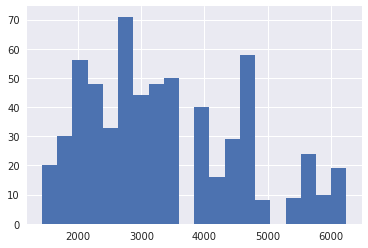

In [37]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-06-01')]['Assigned_Spending_Limit'].hist(bins=20)

In [28]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-06-01')]['Assigned_Spending_Limit'].describe()

count     613.000000
mean     3397.887439
std      1233.476336
min      1430.000000
25%      2340.000000
50%      3120.000000
75%      4390.000000
max      6245.000000
Name: Assigned_Spending_Limit, dtype: float64

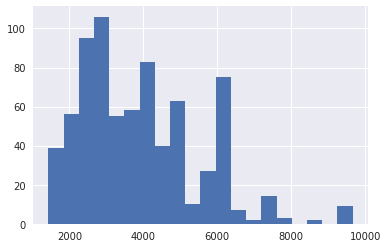

In [38]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-07-01')]['Assigned_Spending_Limit'].hist(bins=20)

In [27]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-07-01')]['Assigned_Spending_Limit'].describe()

count     744.000000
mean     3881.444892
std      1592.624391
min      1430.000000
25%      2645.000000
50%      3570.000000
75%      4800.000000
max      9660.000000
Name: Assigned_Spending_Limit, dtype: float64

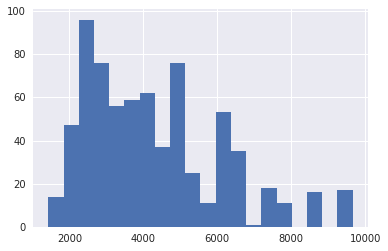

In [39]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-08-01')]['Assigned_Spending_Limit'].hist(bins=20)

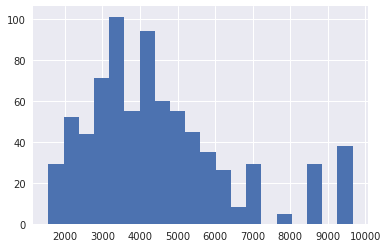

In [40]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-09-01')]['Assigned_Spending_Limit'].hist(bins=20)

In [34]:
fed_bad[(fed_bad['Year_and_Month']==pd.to_datetime('2018-09-01'))&(fed_bad['Assigned_Spending_Limit']==9660)].shape[0]

38

In [36]:
fed_bad[(fed_bad['Year_and_Month']==pd.to_datetime('2018-09-01'))&(fed_bad['Assigned_Spending_Limit']<9660)]['Assigned_Spending_Limit'].describe()

count     738.000000
mean     4260.291328
std      1627.325791
min      1560.000000
25%      3060.000000
50%      3990.000000
75%      5140.000000
max      8650.000000
Name: Assigned_Spending_Limit, dtype: float64

In [32]:
fed_bad['Unique_Order_ID'].nunique()

25548

## Start Constructing data

### 1. Generating Customer Level Data

In [14]:
# Create time_window mark for 18-month data selection later
Perf['time_window'] = Perf['Enrollment_Date'].dt.date + relativedelta(months=18)

In [41]:
Customer.columns

Index(['Unique_Customer_ID', 'Unique_Company_ID', 'Enrollment_Date', 'Assigned_Spending_Limit', 'Customer_Tenure', 'Customer_Salary', 'Prior_Customer_Flag', 'Street1', 'Street2', 'City', 'State', 'Zip', 'Status', 'Term_Date'], dtype='object')

In [15]:
def Perf_filter(df):
    """
    This function takes the Perf dataset and subgroup is with time window condition, 
    then it generates some of the customer-level variables that we expect, such as
    Num_of_Contracts,Total_CO_Balance,Total_Spend
    
    The output would be a customer-level dataframe, where the customers are enrolled in 2017-04 to 2018-04 time period
    """
    
    # Select customers that enrolled in the past 18-30 months (mature)
    df_sub = df[(df['Enrollment_Date'] <= pd.to_datetime('2018-04'))
                & (df['Enrollment_Date'] >= pd.to_datetime('2015-04'))]
    # Get the latest order records
    df_sub = df_sub.loc[df_sub.groupby('Unique_Order_ID')[
        'Year_and_Month'].idxmax()]
    # create customer level data with "# of orders" and "Bad Flag"
    df_sub = df_sub.groupby('Unique_Customer_ID').agg(
        { 'Ever_Bad': 'sum','Order_Amount': 'mean'}).reset_index()
    # The definition of Bad here is whether a customer has at least 1 order goes bad
    df_sub['Bad'] = df_sub['Ever_Bad'] >= 1

    df_sub.rename(columns={'Order_Amount': 'Avg_Spend'}, inplace=True)

    return df_sub

In [16]:
tmp = Perf_filter(Perf)

In [56]:
tmp.shape

(202303, 4)

In [57]:
tmp.head()

,Unique_Customer_ID,Ever_Bad,Avg_Spend,Bad
0,100008346,0,896.640000,False
1,100227894,0,813.998333,False
2,220352799,7,1603.743333,True
3,300631237,4,1460.670000,True
4,300631241,0,666.366250,False


In [17]:
# Let's just call our first merged dataset df..., merge tmp with Customer, we'll have `Customer_Tenure`, 
# `Customer_Tenure` and `Assigned_Spending_Limit`...
df = tmp[['Unique_Customer_ID','Bad','Avg_Spend']].merge(
    Customer[['Unique_Customer_ID','Unique_Company_ID','Assigned_Spending_Limit','Customer_Tenure','Customer_Salary','Enrollment_Date']], how='left', on='Unique_Customer_ID')

In [18]:
df.shape

(202303, 8)

In [19]:
df.head()

,Unique_Customer_ID,Bad,Avg_Spend,Unique_Company_ID,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Enrollment_Date
0,100008346,False,896.640000,1000,6880.0,230.0,59979.00,2016-03-28
1,100227894,False,813.998333,2404,4990.0,162.0,43443.00,2015-05-20
2,220352799,True,1603.743333,2049,8650.0,295.0,78017.00,2015-04-01
3,300631237,True,1460.670000,2311,2325.0,61.0,28909.92,2015-04-01
4,300631241,False,666.366250,2400,3415.0,143.0,33033.00,2015-04-01


In [22]:
df['Year'] = df['Enrollment_Date'].dt.year

In [97]:
df['time_window'] = df['Enrollment_Date'].dt.date - relativedelta(months=12)

In [66]:
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,Employed,NaN
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 Brentwood Ln,NaN,Valley Stream,NY,11581,Employed,NaN
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,Employed,NaN
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 Braddish Ave,NaN,Baltimore,MD,21216,Employed,NaN
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,Employed,NaN


In [65]:
Client.head()

,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,TPA,Launch Date,Termination Date,Affiliate/Fed Gov?
0,Y,7601,Aetna,NaN,NaN,Health Care and Social Assistance,NaN,NaN,NaN,NaN,2017-10-13,NaT,Affiliate
1,Y,1500,PPC SELECT,NaN,NaN,Other Services (except Public Administration),NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,Y,4270,ATLANTIC GENERAL HOSPITAL,418.0,418.0,Health Care and Social Assistance,622110.0,General Medical and Surgical Hospitals,Maryland Hospital Association/PRIME,NaN,2006-03-01,NaT,Affiliate
3,Y,1000,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,EAA,2002-07-01,NaT,Fed Gov
4,Y,3900,"STEPHENS, INC",1000.0,1000.0,Finance and Insurance,523110.0,Investment Banking and Securities Dealing,PPC,NaN,2002-02-01,NaT,Affiliate


### 2. Generating `Client Risk` --- Terminate Rate
- Over the 12m prior to a specific customer's enrollment date, how many customer made orders and how many terminated over that time period.

In [26]:
term_rate = Perf[Perf['Status'] == 'Terminated'].pivot_table(values='Unique_Customer_ID', index='Unique_Company_ID', columns='Year',
                                                 aggfunc='nunique')/Perf.pivot_table(values='Unique_Customer_ID', index='Unique_Company_ID', columns='Year', aggfunc='nunique')

In [29]:
term_rate = term_rate.rename_axis(None, axis=1).reset_index().fillna(0)


In [30]:
term_rate

,Unique_Company_ID,2012,2013,2014,2015,2016,2017,2018,2019
0,1000.0,0.032511,0.032836,0.022597,0.010220,0.006262,0.005232,0.004882,0.004045
1,1011.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1034.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1200.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1301.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1302.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2047.0,0.000725,0.000522,0.000358,0.000000,0.000000,0.000000,0.000000,0.000000
8,2048.0,0.000000,0.002813,0.003906,0.002878,0.003082,0.000000,0.000000,0.000000
9,2049.0,0.000411,0.000497,0.000329,0.000312,0.000202,0.000081,0.000051,0.000000


In [31]:
list(term_rate)

['Unique_Company_ID', 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [32]:
df = df.merge(term_rate[['Unique_Company_ID',2014,2015,2016,2017]], how='left', on='Unique_Company_ID')

In [37]:
df.head()

,Unique_Customer_ID,Bad,Avg_Spend,Unique_Company_ID,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Enrollment_Date,Year,2014,2015,2016,2017,Terminated_Rate
0,100008346,False,896.640000,1000,6880.0,230.0,59979.00,2016-03-28,2016,0.022597,0.010220,0.006262,0.005232,0.010220
1,100227894,False,813.998333,2404,4990.0,162.0,43443.00,2015-05-20,2015,0.000000,0.000000,0.000000,0.000000,0.000000
2,220352799,True,1603.743333,2049,8650.0,295.0,78017.00,2015-04-01,2015,0.000329,0.000312,0.000202,0.000081,0.000329
3,300631237,True,1460.670000,2311,2325.0,61.0,28909.92,2015-04-01,2015,0.474419,0.442357,0.402979,0.300585,0.474419
4,300631241,False,666.366250,2400,3415.0,143.0,33033.00,2015-04-01,2015,0.040179,0.156575,0.158470,0.132021,0.040179


In [ ]:
def match_term_rate(x):
    return x[x['Year']-1]

In [36]:
df['Terminated_Rate'] = df.apply(lambda x: match_term_rate(x),axis=1)

In [102]:
# def term_rate(x):
#     Perf_p12m = Perf[(Perf['Year_and_Month'] <= x['Enrollment_Date']) & (Perf['Year_and_Month'] >= x['time_window']) & (Perf['Unique_Company_ID'] == x['Unique_Company_ID'])]
#     if Perf_p12m['Unique_Customer_ID'].nunique() == 0:
#         return 0
#     else: 
#         return Perf_p12m[(Perf_p12m['Status'] == 'Terminated')]['Unique_Customer_ID'].nunique()/Perf_p12m['Unique_Customer_ID'].nunique()

In [ ]:
# this function could take forever I guess
# df['Terminated_Rate'] = df.apply(lambda x: term_rate(x),axis=1)

In [38]:
df = df.merge(Client[['Client ID','Active','Industry','Affiliate/Fed Gov?']],how='left', left_on = 'Unique_Company_ID',right_on='Client ID')

In [40]:
df = df.drop(['Year',  2014, 2015, 2016, 2017],axis=1)

In [42]:
df = df[df['Active']=='Y']

In [59]:
df.head()

,Unique_Customer_ID,Bad,Avg_Spend,Unique_Company_ID,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Enrollment_Date,Terminated_Rate,Client ID,Active,Industry,Affiliate/Fed Gov?,Channel
0,100008346,False,896.640000,1000,6880.0,230.0,59979.0,2016-03-28,0.010220,1000.0,Y,Federal Government/Associations,Fed Gov,1
1,100227894,False,813.998333,2404,4990.0,162.0,43443.0,2015-05-20,0.000000,2404.0,Y,Local Government/Associations,Affiliate,0
2,220352799,True,1603.743333,2049,8650.0,295.0,78017.0,2015-04-01,0.000329,2049.0,Y,Federal Government/Associations,Fed Gov,1
4,300631241,False,666.366250,2400,3415.0,143.0,33033.0,2015-04-01,0.040179,2400.0,Y,Retail Trade,Affiliate,0
5,300631246,False,532.117000,2302,2150.0,73.0,31574.4,2015-04-01,0.519501,2302.0,Y,Retail Trade,Affiliate,0


In [43]:
df.shape

(189852, 13)

### A Dirty Decsion Tree

In [44]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [47]:
df.shape

(189852, 13)

In [50]:
df.iloc[2:3,:]

,Unique_Customer_ID,Bad,Avg_Spend,Unique_Company_ID,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Enrollment_Date,Terminated_Rate,Client ID,Active,Industry,Affiliate/Fed Gov?
2,220352799,True,1603.743333,2049,8650.0,295.0,78017.0,2015-04-01,0.000329,2049.0,Y,Federal Government/Associations,Fed Gov


In [142]:
X_train = df.sort_values('Enrollment_Date').iloc[:133000,:].drop(['Client ID','Unique_Customer_ID','Enrollment_Date','Unique_Company_ID','Bad','Active','Industry','Affiliate/Fed Gov?','Assigned_Spending_Limit'],axis=1)
y_train = df.sort_values('Enrollment_Date').iloc[:133000,:]['Bad']

X_test = df.sort_values('Enrollment_Date').iloc[133000:,:].drop(['Client ID','Unique_Customer_ID','Enrollment_Date','Unique_Company_ID','Bad','Active','Industry','Affiliate/Fed Gov?','Assigned_Spending_Limit'],axis=1)
y_test = df.sort_values('Enrollment_Date').iloc[133000:,:]['Bad']

In [ ]:
# X = df.drop(['Client ID','Unique_Customer_ID','Unique_Company_ID','Bad'],axis=1)
# y = df['Bad']

In [ ]:
# Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34) # 70% training and 30% test

In [52]:
X_train.head()

,Avg_Spend,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Enrollment_Date,Terminated_Rate,Active,Industry,Affiliate/Fed Gov?
77,1406.508571,5505.0,56.0,52772.00,2015-04-01,0.260331,Y,Finance and Insurance,Affiliate
93,713.150000,1335.0,68.0,18585.21,2015-04-01,0.371173,Y,Nursing and Residential Care Facilities,Affiliate
92,964.537500,12765.0,85.0,105516.00,2015-04-01,0.040974,Y,State Government/Associations,Affiliate
91,1398.250000,900.0,11.0,26325.00,2015-04-01,0.349538,Y,Health Care and Social Assistance,Affiliate
131,587.100000,2355.0,263.0,20000.00,2015-04-01,0.481159,Y,Information,Affiliate


In [103]:
# one_hot_data = 
df['Channel'] = pd.get_dummies(df[['Affiliate/Fed Gov?']],drop_first=True)

In [143]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=5,criterion="entropy",min_samples_leaf=10,min_samples_split=50)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict_proba(X_test)

In [140]:
y_pred[:,1]

array([0.60767782, 0.45906232, 0.30012453, ..., 0.60767782, 0.60767782,
       0.22256245])

In [120]:
from sklearn.metrics import roc_auc_score

In [144]:
roc_auc_score(y_test, y_pred[:,1])

0.6630263496140436

In [127]:
X_test['pred'] = y_pred[:,1]
X_test['Bad'] = y_test

In [137]:
def makeKS( df, variable, target, number_of_cuts, sorting='+'):
    df = df[[variable,target]].copy(deep=True)
    if sorting == '-':
        df[variable] = -df[variable]
    df['dec'] = pd.qcut(df[variable], q=number_of_cuts, labels=np.arange(1, number_of_cuts+1, 1))
    
    all_bads = df.loc[df[target] == 1].shape[0]
    all_goods = df.loc[df[target] == 0].shape[0]
    d_bads = [0]
    d_goods = [0]
    bads_seen = 0
    goods_seen = 0
    
    for i in range(1, number_of_cuts+1):
        cur_bads = df.loc[(df.dec == i) & (df[target] == 1)].shape[0]
        cur_goods = df.loc[(df.dec == i) & (df[target] == 0)].shape[0]
        bads_seen += cur_bads
        goods_seen += cur_goods
        d_bads.append(bads_seen)
        d_goods.append(goods_seen)
        
    d_bads = np.array(d_bads) / all_bads
    d_goods = np.array(d_goods) / all_goods
    d_diffs = abs(d_goods - d_bads)   
    ks_idx = np.argmax(d_diffs)
    KS = max(d_diffs)
        
    x0 = ks_idx
    y0 = d_goods[ks_idx]
    y1 = d_bads[ks_idx]
        
    fig = plt.figure(figsize=(14, 8))
    ax = plt.axes()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
#     plt.title(f'KS for {segmentation} {sample} {variable}',fontsize=20)
    plt.plot([x0, x0], [y0, y1], color="green", linestyle='--')  # the ks diff
    plt.plot(list(range(0, number_of_cuts+1)), d_goods, color="orange", label="Goods - Model")
    plt.plot(list(range(0, number_of_cuts+1)), d_bads, color="blue", label="Bads - Model")
    plt.plot([], [], ' ', label="Model KS:  %s" % round(KS, 3))
    plt.xlabel('Number of Model Cuts',fontsize=14)
    plt.ylabel("Cumulative Percentage of Goods/Bads",fontsize=14)
    plt.legend(loc="lower right",fontsize=16)
    ax.set(ylim=(0,1))
    ax.set(xlim=(0,number_of_cuts))
#     seaborn.despine()
    figure = ax.get_figure()
#     pdf.savefig(figure)

#     raw_data = pandas.DataFrame({'buckets':list(range(0, number_of_cuts+1)),
#                                 'cuml_goods':d_goods,
#                                 'cuml_bads':d_bads})
#     raw_data['difference'] = raw_data.cuml_goods - raw_data.cuml_bads
#     logging.info(f'Writing KS for {segmentation} {sample} {variable} at /outputs/most_recent/model_validation/ks_{segmentation}_{sample}_{variable}.csv')
#     raw_data.to_csv(f'./outputs/most_recent/model_validation/ks_{segmentation}_{sample}_{variable}.csv', index=False)
    #figure = ax.get_figure()
    #pdf.savefig(figure)
    
    return KS

0.24947806655151805

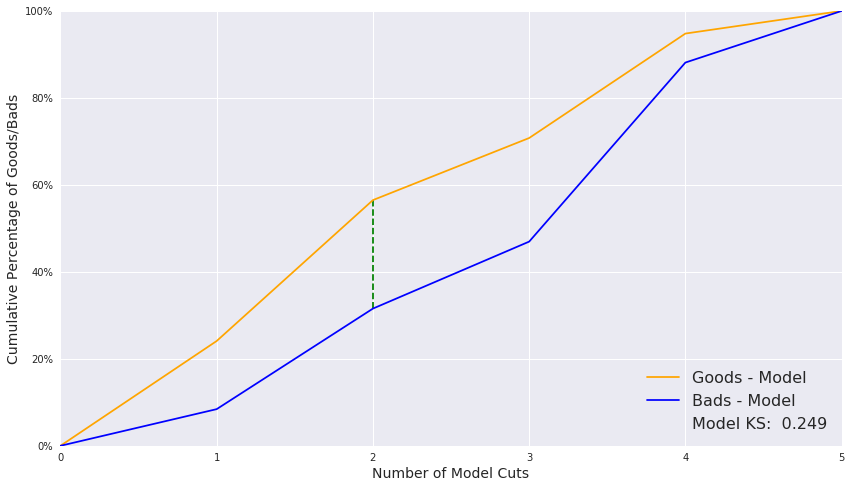

In [138]:
makeKS(X_test,'pred','Bad',5)

In [122]:
def makeAUC( df, compare_vars, signs, target):
    fpr = {}
    tpr = {}
    auc_values = {}
    
    transforms = dict(zip(compare_vars, signs))
    for var in compare_vars:
        fpr[var], tpr[var], thresholds = sklearn.metrics.roc_curve(df[target].values, transforms[var] * df[var].values)
    
    plt.close('all')  
    fig = plt.figure(figsize=(14, 8))
    ax = plt.axes()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    lw = 3

    for var in fpr.keys():
        auc = sklearn.metrics.roc_auc_score(df[target].values, transforms[var] * df[var].values)
        plt.plot(fpr[var], tpr[var],
                 lw=lw, label='{} ROC curve = {}'.format(var, round(auc,3)))
        auc_values.update({var:auc})

    percent_increase = auc_values[compare_vars[0]]/auc_values[compare_vars[1]]-1
    
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([0., 1.])
    plt.ylim([0., 1.])
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
#     plt.title(f'ROC Comparison for {segmentation} {sample}',fontsize=20)
    plt.plot([], [], ' ', label=f"Increased AUC by {'{:.1%}'.format(percent_increase)}")
    plt.legend(loc='lower right',fontsize=16,frameon=False)
    seaborn.despine()
    figure = ax.get_figure()
#     pdf.savefig(figure)
    
    return auc_values

In [123]:
makeAUC(X_test, y_pred,1,'Bad')

TypeError: zip argument #2 must support iteration

In [74]:
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [110]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = list(X_train),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

InvocationException: Program terminated with status: 1. stderr follows: Warning: Could not load "/home/ec2-user/anaconda3/lib/graphviz/libgvplugin_pango.so.6" - file not found
Warning: Could not load "/home/ec2-user/anaconda3/lib/graphviz/libgvplugin_pango.so.6" - file not found
Format: "png" not recognized. Use one of: canon cmap cmapx cmapx_np dot dot_json eps fig gv imap imap_np ismap json json0 mp pdf pic plain plain-ext png pov ps ps2 svg svgz tk vml vmlz xdot xdot1.2 xdot1.4 xdot_json


In [22]:
Perf_p12m = Perf[(Perf['Year_and_Month'] <= pd.to_datetime('2015-04'))              
                & (Perf['Year_and_Month'] >= pd.to_datetime('2014-04'))]

In [23]:
# Get Total CO Balance per Client
client_loss = Perf_p12m[(Perf_p12m['Bad'] == 1) & (
    Perf_p12m['Ever_Bad'] <= 1)].groupby('Unique_Company_ID')['2os_loss'].sum().reset_index()

In [24]:
# Get Total Spend per Client
client_order_vol = Perf_p12m.groupby(['Unique_Company_ID', 'Unique_Order_ID']).head(
    1).groupby('Unique_Company_ID')['Order_Amount'].sum().reset_index()

In [25]:
# I really don't know how to name this dataset
client_loss_m = client_loss.merge(client_order_vol, how='right',on='Unique_Company_ID')

In [26]:
client_loss_m.head()

,Unique_Company_ID,2os_loss,Order_Amount
0,1000.0,216543.28,11203596.54
1,1200.0,17430.36,710638.32
2,1301.0,60.60,6820.50
3,1302.0,538.91,50913.44
4,1500.0,3379.07,1679927.63


In [27]:
client_loss_m['Client_Risk'] = client_loss_m['2os_loss']/client_loss_m['Order_Amount']

In [28]:
# Some client may have no loss where 2os_loss is NaN, resulting loss_rate == NaN, fill these with 0
client_loss_m =  client_loss_m.fillna(0)

In [29]:
# Now merge the Clint risk to our first merged dataset df
df = df.merge(client_loss_m[['Unique_Company_ID','Client_Risk']], how = 'left',on= 'Unique_Company_ID')

### 3. Final Steps..

In [30]:
# Customers with missing `Client_Risk` means their company don't have any orders prior(12m) to their enrollment
# Some Salary number seems to be ridiculous, treat them as outliers
final = df[(df['Client_Risk'].notnull())&(df['Customer_Salary']>2000) &(df['Customer_Salary']!=9999999.99)]

In [31]:
# See the summary of important features
final[['Customer_Tenure','Customer_Salary','Assigned_Spending_Limit','Client_Risk','Num_of_Contracts','Total_CO_Balance','Total_Spend']].describe()

,Customer_Tenure,Customer_Salary,Assigned_Spending_Limit,Client_Risk,Num_of_Contracts,Total_CO_Balance,Total_Spend
count,72031.000000,72031.000000,72031.000000,72031.000000,72031.000000,72031.000000,72031.000000
mean,79.702989,41366.802059,3658.995904,0.027663,4.273466,234.993017,3089.612642
std,71.252333,19453.695191,2228.914229,0.026077,5.094489,655.422507,3153.956408
min,1.000000,2308.000000,400.000000,0.000000,1.000000,0.000000,11.380000
25%,38.000000,29827.200000,1875.000000,0.002049,1.000000,0.000000,1018.835000
50%,50.000000,35741.000000,3260.000000,0.033255,3.000000,0.000000,2058.390000
75%,90.000000,47819.200000,4930.000000,0.035308,5.000000,0.000000,4016.765000
max,634.000000,762720.000000,13160.000000,0.316066,103.000000,9959.360000,41403.970000


In [176]:
# final.isnull().sum(axis=0)

## Big Time: Output the final dataset

In [ ]:
final.to_csv(output_path + filename +'.csv')

In [ ]:
#----------------------------------------------- END ------------------------------------------------------#

In [32]:
final.shape

(72031, 19)

In [33]:
final.head()

,Unique_Customer_ID,Bad,Num_of_Contracts,Total_CO_Balance,Total_Spend,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Client_Risk
0,302641212,False,1,0.0,1889.29,2183,2017-04-01,7260.0,317.0,47196.00,First Time Byer,214 S KESSING ST,NaN,PORTERVILLE,CA,93257,Employed,NaN,0.021343
1,302641217,False,1,0.0,304.34,2302,2017-04-01,500.0,44.0,11804.00,First Time Byer,6580 MORET DR S,NaN,JACKSONVILLE,FL,32244,Direct Bill,NaN,0.033438
2,302641220,False,3,0.0,4516.09,2250,2017-04-01,2940.0,34.0,34037.38,Repeat Buyer,2967 GORDON RD,NaN,ROCK HILL,SC,29732,Employed,NaN,0.040143
3,302641222,False,15,0.0,7546.45,2425,2017-04-01,3065.0,43.0,35495.09,Repeat Buyer,9231 S CYPRESS CIR,NaN,MIRAMAR,FL,33025,Employed,NaN,0.068904
4,302641226,False,13,0.0,8152.89,2464,2017-04-01,1500.0,33.0,55823.00,Repeat Buyer,2266 S HARWOOD AVE,NaN,UPPER DARBY,PA,19082,Direct Bill,NaN,0.002049


In [34]:
def view(var,df):
    print('Spending Limit by {}'.format(var))
    df[var+'_bin'] = pd.qcut(df[var], q=4)
    return df.groupby(var+'_bin').agg({'Assigned_Spending_Limit':'mean','Unique_Customer_ID':'count'}).round(2)

In [35]:
view('Customer_Salary',final)

Spending Limit by Customer_Salary


,Assigned_Spending_Limit,Unique_Customer_ID
Customer_Salary_bin,,
"(2307.999, 29827.2]",1605.42,18010
"(29827.2, 35741.0]",2722.55,18006
"(35741.0, 47819.2]",4046.47,18009
"(47819.2, 762720.0]",6261.94,18006


In [120]:
view('Customer_Tenure',final)

Spending Limit by Customer_Tenure


,Assigned_Spending_Limit,Unique_Customer_ID
Customer_Tenure_bin,,
"(0.999, 38.0]",2953.69,19592
"(38.0, 50.0]",3025.98,16588
"(50.0, 90.0]",3814.54,17910
"(90.0, 634.0]",4859.21,17941


In [121]:
view('loss_rate',final)

Spending Limit by loss_rate


,Assigned_Spending_Limit,Unique_Customer_ID
loss_rate_bin,,
"(-0.001, 0.00205]",3187.45,18539
"(0.00205, 0.0333]",4359.32,18094
"(0.0333, 0.0353]",3662.20,18628
"(0.0353, 0.316]",3421.10,16770


In [122]:
def risk_view(var,df):
    print('Bad Rate by {}'.format(var))
    df[var+'_bin'] = pd.qcut(df[var], q=4)
    return df.groupby(var+'_bin')['Bad'].sum().div(df.groupby(var+'_bin')['Unique_Customer_ID'].size())

In [123]:
risk_view('Customer_Salary',final)

Bad Rate by Customer_Salary


Customer_Salary_bin
(2307.999, 29827.2]    0.362132
(29827.2, 35741.0]     0.273131
(35741.0, 47819.2]     0.177578
(47819.2, 762720.0]    0.136621
dtype: float64

In [124]:
risk_view('Customer_Tenure',final)

Bad Rate by Customer_Tenure


Customer_Tenure_bin
(0.999, 38.0]    0.281748
(38.0, 50.0]     0.312696
(50.0, 90.0]     0.227192
(90.0, 634.0]    0.129424
dtype: float64

In [173]:
risk_view('Client_Risk',final)

Bad Rate by Client_Risk


Client_Risk_bin
(-0.001, 0.00205]    0.222018
(0.00205, 0.0333]    0.188792
(0.0333, 0.0353]     0.245491
(0.0353, 0.316]      0.297734
dtype: float64

In [174]:
print('Bad Rate vs Spending Limit')
final['Spending_Limit_bin'] = pd.qcut(final['Assigned_Spending_Limit'], q=6)
final.groupby('Spending_Limit_bin')['Bad'].sum().div(final.groupby('Spending_Limit_bin')['Unique_Customer_ID'].size())

Bad Rate vs Spending Limit


Spending_Limit_bin
(399.999, 1445.0]    0.365557
(1445.0, 2330.0]     0.312217
(2330.0, 3260.0]     0.267938
(3260.0, 4335.0]     0.212948
(4335.0, 5620.0]     0.154103
(5620.0, 13160.0]    0.108509
dtype: float64